# Training a Simple GAN Model for Sentence Embeddings

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import pandas as pd
import ast
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot as plt
from keras import backend
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
z
np.random.seed(42)
MAX_LENGTH = 768


2024-04-14 18:02:05.441631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing Data

In [2]:
#Limit number of rows for experimentation
df = pd.read_csv('../data/author_csv.csv')
num_rows = len(df)
df = df[:num_rows]
df

,Unnamed: 0,author_labels,cls_tokens
0,0,1,"[0.278237104415893, -0.33750003576278603, 0.84..."
1,1,1,"[-0.13946822285652102, 0.093057677149772, 0.73..."
2,2,1,"[-1.493581295013427, 0.748962104320526, 1.0086..."
3,3,1,"[-0.9141901135444641, 0.6804959774017331, 0.90..."
4,4,1,"[0.040547348558902005, 0.08085644245147701, 1...."
...,...,...,...
32592,32592,0,"[0.036508537828922, -0.9830706119537351, 0.194..."
32593,32593,0,"[-0.49513417482376104, -0.42453348636627203, 0..."
32594,32594,0,"[-0.6720252633094781, -0.37544131278991705, 2...."
32595,32595,0,"[0.153745874762535, -0.533583104610443, -0.371..."


In [3]:
df['author_labels'].value_counts()

author_labels
1    27903
0     2352
2     2342
Name: count, dtype: int64

In [4]:
# Load the text lines
n_classes = df['author_labels'].nunique()

embeddings = df['cls_tokens']

#Turn EagerTensors list to Normal Tensors list
embeddings_pytorch = [torch.tensor(np.array(ast.literal_eval(e)), dtype=torch.float32) for e in embeddings]

# Convert list of tensors to a single tensor
embeddings_tensor = torch.stack(embeddings_pytorch).squeeze(1)  # Adjust dimensions as needed

embeddings_tensor

tensor([[ 0.2782, -0.3375,  0.8478,  ..., -0.7637, -0.5338,  0.3607],
        [-0.1395,  0.0931,  0.7390,  ...,  0.8308, -0.3973,  1.1339],
        [-1.4936,  0.7490,  1.0087,  ...,  1.5033, -1.2829, -0.5658],
        ...,
        [-0.6720, -0.3754,  2.1211,  ...,  1.0377, -0.6048, -0.7254],
        [ 0.1537, -0.5336, -0.3715,  ...,  1.6371,  0.6499, -0.5228],
        [-0.7284, -0.3828, -0.2024,  ...,  1.4613,  0.1921,  1.5803]])

In [5]:
embeddings_tensor.shape

torch.Size([32597, 768])

In [6]:
#Initialize Dataset
embeddings = embeddings_tensor 

# Instantiate the custom dataset

# Training the SGAN Model

In [7]:
X = embeddings_tensor
y = df['author_labels'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)
print(X_test.shape)
print(y_test.shape)

torch.Size([8150, 768])
(8150,)


The next code block contains all the helper functions and the training script. The main functions to look at are the 
define_discriminator, define_generator, and define_gan functions. They contain the model architecture for the discriminator and generator functions.

In [8]:
lr = 3e-4
n_samples = 2000
n_epochs = 2
loss_var_threshold = 0.01
latent_dim=500

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(MAX_LENGTH,), n_classes=df['author_labels'].nunique()):
    
  # Embedding input
  in_image = Input(shape=in_shape)

  # downsample
  fe = Dense(units=100, activation='sigmoid')(in_image)
  fe = LeakyReLU(negative_slope=0.2)(fe)

  # downsample
  fe = Dense(units=100, activation='sigmoid')(in_image)
  fe = LeakyReLU(negative_slope=0.2)(fe)
    
  # dropout
  fe = Dropout(0.2)(fe)

  # output layer nodes
  fe = Dense(n_classes)(fe)
    
  # supervised output
  c_out_layer = Activation('softmax')(fe)
    
  # define and compile supervised discriminator model
  c_model = Model(in_image, c_out_layer, name = "supervised_discrimminator")
  c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr, beta_1=0.5), metrics=['accuracy'])
    
  # unsupervised output
  d_out_layer = Dense(units = n_classes + 1, activation = 'softmax')(fe)
    
  # define and compile unsupervised discriminator model
  d_model = Model(in_image, d_out_layer, name = "discriminator-fake")
  d_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr, beta_1=0.5), metrics = ['accuracy'])
  d_model.trainable = True
  c_model.trainable = True
    
  return d_model, c_model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=MAX_LENGTH):
	model = Sequential(name = "Generator")
	model.add(Dense(200, activation='sigmoid', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(100, activation='sigmoid'))
	model.add(Dense(n_outputs, activation='tanh'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # Ensure the discriminator's parameters are not trainable in the combined model
    discriminator.trainable = False
    
    # Create a new input layer for the GAN (noise sample)
    gan_input = Input(shape=(latent_dim,))
    
    # Output of the generator
    generator_output = generator(gan_input)
    
    # Output of the discriminator (takes generator's output as input)
    gan_output = discriminator(generator_output)
    
    # Define the GAN model
    gan = Model(gan_input, gan_output, name = 'gan-model')
    
    # Compile the GAN model
    optimizer = Adam(learning_rate=lr)
    gan.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
    
    return gan


# load the embeddings and classifications
def load_real_samples(X,y):
	print(X.shape, y.shape)
	return [X, y]

# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=n_samples, n_classes=df['author_labels'].nunique()):
    X, y = dataset
    n_per_class = int(n_samples / n_classes)
    X_samples = []
    y_samples = []

    for class_index in range(n_classes):
        
        # Find the indices of all samples belonging to the current class
        class_indices = np.where(y == class_index)[0]
        
        # Randomly choose n_per_class indices for this class
        selected_indices = np.random.choice(class_indices, n_per_class, replace=False)
        # Append the selected samples to the lists
        X_samples.append(X[selected_indices])
        y_samples.append(y[selected_indices])
    
    # Concatenate all selected samples
    X_samples = np.concatenate(X_samples, axis=0)
    y_samples = np.concatenate(y_samples, axis=0)
    return X_samples, y_samples

    
def generate_real_samples(dataset, n_samples = n_samples):
    features, labels = dataset
    # Generate random indices
    indices = np.random.choice(features.shape[0], n_samples, replace=False)
    # Select a random subset of features and labels using the indices
    X = features[indices]
    labels = labels[indices]
    return X, labels

def generate_real_samples_multiclass(dataset, n_samples = n_samples):
    features, labels = dataset
    # Generate random indices
    indices = np.random.choice(features.shape[0], n_samples, replace=False)
    # Select a random subset of features and labels using the indices
    X = features[indices]
    labels = labels[indices]
    # Generate class labels (assuming you want all ones for real samples)
    y = np.ones((n_samples, 1))
    return [X, labels], y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = ones((n_samples, 1)) * n_classes
	return images, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, acc_list, n_samples=100):
    
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
    
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	acc_list.append(acc)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))


# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, acc_list, n_epochs=n_epochs, n_batch=100):
    print(f'Latent dimensions: {latent_dim}\n-------------')
    # Initialize lists to track losses
    c_losses, d_losses, g_losses = [], [], []
    loss_variance_threshold = loss_var_threshold  # Set a threshold for the variance
    min_epochs = 5  # Set a minimum number of epochs to prevent stopping too early
    
    # select supervised dataset
    X_sup, y_sup = X_train, y_train
    print(X_sup.shape, y_sup.shape)
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    
    # manually enumerate epochs
    for i in range(n_steps):
        
        # update supervised discriminator (c)
        Xsup_real, ysup_real = generate_real_samples([X_sup, y_sup], n_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
        
        # update discriminator (d) on real samples
        X_real, y_real = generate_real_samples(dataset, n_batch)
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)  # Capture loss and accuracy
        
        # update unsupervised discriminator (d) on fake samples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)  # Capture loss and accuracy

        
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        # summarize loss on this batch
        print('>%d, c(loss and accuracy)[%.3f,%.0f], d(loss on real and fake)[%.3f,%.3f], d(acc on real and fake)[%.3f,%.3f], g(loss)[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, d_acc1 * 100, d_acc2 * 100, g_loss))
        
        # evaluate the model performance every so often
        if (i+1) % (100) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset, acc_list)
    
        # At the end of each epoch (or defined interval) in training loop:
        c_losses.append(c_loss)
        d_losses.append((d_loss1 + d_loss2) / 2)
        g_losses.append(g_loss)
        
        # Calculate the variance of the last N losses to check for stability
        if len(c_losses) > min_epochs * (i + 1):  # Ensure we have enough data to make a meaningful decision
            recent_c_var = np.var(c_losses[-min_epochs:])
            recent_d_var = np.var(d_losses[-min_epochs:])
            recent_g_var = np.var(g_losses[-min_epochs:])
            
            # Check if all losses have stabilized
            if recent_c_var < loss_variance_threshold and recent_d_var < loss_variance_threshold and recent_g_var < loss_variance_threshold:
                print(f"Stopping training at epoch {i+1} due to stabilized losses.")
                break



In [9]:
def def_models(latent_dim):
    d_model, c_model = define_discriminator()
    g_model = define_generator(latent_dim)
    gan_model = define_gan(g_model, d_model)
    d_model.trainable = True
    c_model.trainable = True
    gan_model.trainable = True
    g_model.trainable = True
    return d_model, c_model, g_model, gan_model

def train_script(latent_dim, dataset):
    d_model, c_model, g_model, gan_model = def_models(latent_dim)

    train(g_model, d_model, c_model, gan_model, dataset, latent_dim, acc_list=[])
    return c_model, d_model, g_model, gan_model


### Generating Predictions and Evaluating Model Performance

In [10]:
dataset = load_real_samples(X_train,y_train)

best_c_model, best_d_model, best_g_model, best_gan = train_script(latent_dim=500, dataset=dataset)

torch.Size([24447, 768]) (24447,)
Latent dimensions: 500
-------------
torch.Size([24447, 768]) (24447,)
n_epochs=2, n_batch=100, 1/2=50, b/e=244, steps=488


/Users/thossain64/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>1, c(loss and accuracy)[1.737,10], d(loss on real and fake)[1.326,1.246], d(acc on real and fake)[45.000,28.500], g(loss)[0.935]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>2, c(loss and accuracy)[1.719,14], d(loss on real and fake)[1.223,1.205], d(acc on real and fake)[40.000,32.000], g(loss)[0.876]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>3, c(loss and accuracy)[1.737,12], d(loss on real and fake)[1.193,1.179], d(acc on real and fake)[37.800,31.833], g(loss)[0.833]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>4, c(loss and accuracy)[1.726,12], d(loss on real and fake)[1.168,1.165], d(acc on real and fake)[36.857,32.375], g(loss)[0.790]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
>5, c(loss and accuracy)[1.713,11], d(loss on real and fake)[1.157,1.154], d(acc on real and fake)[36.667,33.100], g(loss)[0.754]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
>6, c(loss and accuracy)[1.714,11], d(loss on real and fake)[1.148,1.150], d(acc on real and fake)[37.000,34.000], g(loss)

In [11]:
best_c_model.summary()

Model: "supervised_discrimminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,611 (904.73 KB)

 Trainable params: 77,203 (301.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,408 (603.16 KB)

In [12]:
best_d_model.summary()

Model: "discriminator-fake"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,659 (904.92 KB)

 Trainable params: 77,219 (301.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,440 (603.29 KB)

Generating Fake Data for Model Evaluation

In [13]:
## Creating Fake Data

n_classes = 3

# Augmenting Test Data
fake_test_tokens, fake_test_labels = generate_fake_samples(best_g_model, latent_dim=500, n_samples=int(X_test.shape[0] / n_classes))

X_test_with_fakes = np.concatenate((X_test, fake_test_tokens), axis = 0)
y_test_with_fakes = np.concatenate((y_test, fake_test_labels.flatten()), axis = 0)

indices = tf.range(start=0, limit=tf.shape(X_test_with_fakes)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

X_test_with_fakes = tf.gather(X_test_with_fakes, shuffled_indices)
y_test_with_fakes = tf.gather(y_test_with_fakes, shuffled_indices)


#Augmenting Train Data
fake_train_tokens, fake_train_labels = generate_fake_samples(best_g_model, latent_dim=500, n_samples=int(X_train.shape[0] / n_classes))

X_train_with_fakes = np.concatenate((X_train, fake_train_tokens), axis=0)
y_train_with_fakes = np.concatenate((y_train, fake_train_labels.flatten()), axis=0)

indices = tf.range(start=0, limit=tf.shape(X_train_with_fakes)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

X_train_with_fakes = tf.gather(X_train_with_fakes, shuffled_indices)
y_train_with_fakes = tf.gather(y_train_with_fakes, shuffled_indices)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 1.0, 'Class distribution in Balanced (Undersampled) Test Dataset')

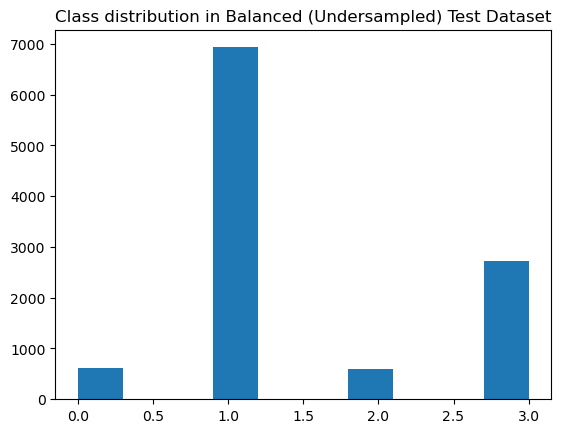

In [14]:
plt.hist(y_test_with_fakes)
plt.title("Class distribution in Balanced (Undersampled) Test Dataset")

Text(0.5, 1.0, 'Class distribution in Balanced (Undersampled) Train Dataset')

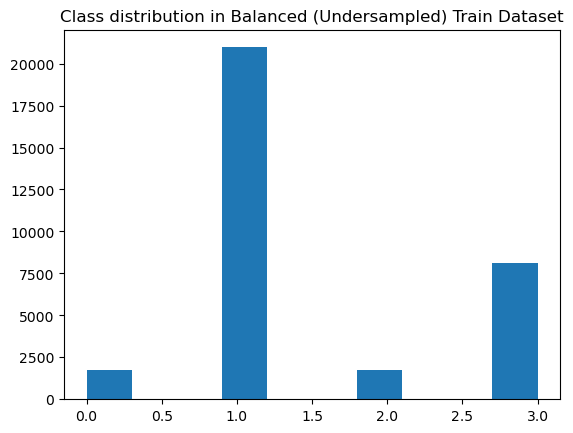

In [15]:
plt.hist(y_train_with_fakes)
plt.title("Class distribution in Balanced (Undersampled) Train Dataset")

Generate Predictions from the Discriminator Classifier

In [16]:
# Test Set Predictions 
d_test_predictions = best_d_model.predict(X_test_with_fakes)
d_test_predicted_labels = d_test_predictions.argmax(axis=1)
d_test_loss, d_test_accuracy = best_d_model.evaluate(X_test_with_fakes, y_test_with_fakes)

test_discriminator_classification_report = classification_report(y_test_with_fakes, d_test_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns', 'Generated CLS'])

# Train Set Predictions
d_train_preds = best_d_model.predict(X_train_with_fakes)
d_train_predicted_labels = d_train_preds.argmax(axis=1)
d_train_loss, d_train_acc = best_d_model.evaluate(X_train_with_fakes, y_train_with_fakes)  # Corrected line

train_discriminator_classification_report = classification_report(y_train_with_fakes, d_train_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns', 'Generated CLS'])


340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6367 - loss: 0.9439
 115/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step

/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.6452 - loss: 0.9265


/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generate Predictions from the Baseline Classifier

In [17]:
#Test Set Predictions
c_test_predictions = best_c_model.predict(X_test)
c_test_predicted_labels = c_test_predictions.argmax(axis=1)
c_test_loss, c_test_accuracy = best_c_model.evaluate(X_test, y_test)

test_baseline_classification_report = classification_report(y_test, c_test_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns'])

# Train Set Predictions
c_train_predictions = best_c_model.predict(X_train)
c_train_predicted_labels = c_train_predictions.argmax(axis=1)
c_train_loss, c_train_accuracy = best_c_model.evaluate(X_train, y_train)

train_baseline_classification_report = classification_report(y_train, c_train_predicted_labels, target_names=['Hesiod', 'Homer', 'Homeric Hymns'])


255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.8465 - loss: 0.7011
118/764 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step

/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


764/764 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
764/764 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.8506 - loss: 0.6912


/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thossain64/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance Metrics

In [18]:
print("Discriminator Testing Set Performance: Imbalanced Dataset")
print(test_discriminator_classification_report)
print("")
print("discriminator test loss: ", d_test_loss)
print("discriminator test accuracy: ", d_test_accuracy)

Discriminator Testing Set Performance: Imbalanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.00      0.00      0.00       613
        Homer       0.64      1.00      0.78      6931
Homeric Hymns       0.00      0.00      0.00       606
Generated CLS       0.00      0.00      0.00      2716

     accuracy                           0.64     10866
    macro avg       0.16      0.25      0.19     10866
 weighted avg       0.41      0.64      0.50     10866


discriminator test loss:  0.9413930773735046
discriminator test accuracy:  0.6378611922264099


In [19]:
print("Baseline Testing Set Performance: Imbalanced Dataset")
print(test_baseline_classification_report)
print("")
print("baseline test loss: ", c_test_loss)
print("baseline test accuracy: ", c_test_accuracy)

Baseline Testing Set Performance: Imbalanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.07      0.01      0.01       613
        Homer       0.85      0.99      0.91      6931
Homeric Hymns       0.00      0.00      0.00       606

     accuracy                           0.84      8150
    macro avg       0.31      0.33      0.31      8150
 weighted avg       0.73      0.84      0.78      8150


baseline test loss:  0.7072656154632568
baseline test accuracy:  0.842699408531189


In [20]:
print("Discriminator Training Set Performance: Imbalanced Dataset")
print(train_discriminator_classification_report)
print("")
print("discriminator train loss: ", d_train_loss)
print("discriminator train accuracy: ", d_train_acc)

Discriminator Training Set Performance: Imbalanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.00      0.00      0.00      1739
        Homer       0.64      1.00      0.78     20972
Homeric Hymns       0.00      0.00      0.00      1736
Generated CLS       0.00      0.00      0.00      8149

     accuracy                           0.64     32596
    macro avg       0.16      0.25      0.20     32596
 weighted avg       0.41      0.64      0.50     32596


discriminator train loss:  0.9289253354072571
discriminator train accuracy:  0.6433918476104736


In [21]:
print("Baseline Training Set Performance: Imbalanced Dataset")
print(train_baseline_classification_report)
print("")
print("baseline train loss: ", c_train_loss)
print("baseline train accuracy: ", c_train_accuracy)

Baseline Training Set Performance: Imbalanced Dataset
               precision    recall  f1-score   support

       Hesiod       0.03      0.00      0.01      1739
        Homer       0.86      0.99      0.92     20972
Homeric Hymns       0.00      0.00      0.00      1736

     accuracy                           0.85     24447
    macro avg       0.29      0.33      0.31     24447
 weighted avg       0.74      0.85      0.79     24447


baseline train loss:  0.6948044896125793
baseline train accuracy:  0.8482022285461426


Data Export for Further Analysis 

In [23]:
## Baseline Data Export 

baseline_test_predictions = pd.DataFrame({"baseline_test_labels": y_test, 
                                          "baseline_test_preds": c_test_predicted_labels})

baseline_train_predictions = pd.DataFrame({"baseline_train_labels": y_train, 
                                          "baseline_train_preds": c_train_predicted_labels})

baseline_train_predictions.to_csv("imbalanced_baseline_train_predictions.csv", index=True)
baseline_test_predictions.to_csv("imbalanced_baseline_test_predictions.csv", index=True)

X_test_numpy = X_test.numpy()
X_train_numpy = X_train.numpy()

# Convert numpy array to DataFrame
X_test_df = pd.DataFrame(X_test_numpy)
X_train_df = pd.DataFrame(X_train_numpy)

# Save the DataFrame to a CSV file
X_test_df.to_csv('imbalanced_baseline_X_test.csv', index=True)
X_train_df.to_csv('imbalanced_baseline_X_train.csv', index=True)

In [24]:
## Discriminator Data Export 

discrim_test_predictions = pd.DataFrame({"discrim_test_labels": y_test_with_fakes, 
                                         "discrim_test_preds": d_test_predicted_labels})

discrim_train_predictions = pd.DataFrame({"discrim_train_labels": y_train_with_fakes, 
                                          "discrim_train_preds": d_train_predicted_labels})

discrim_test_predictions.to_csv("imbalanced_discrim_test_predictions.csv", index=True)
discrim_train_predictions.to_csv("imbalanced_discrim_train_predictions.csv", index=True)

discrim_X_test_numpy = X_test_with_fakes.numpy()
discrim_X_train_numpy = X_train_with_fakes.numpy()

discrim_X_test_df = pd.DataFrame(discrim_X_test_numpy)
discrim_X_train_df = pd.DataFrame(discrim_X_train_numpy)

discrim_X_test_df.to_csv('imbalanced_discrim_X_test.csv', index=True)
discrim_X_train_df.to_csv('imbalanced_discrim_X_train.csv', index=True)